**MAKING PICTURES

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim

from utils.inpainting_utils import *


        

#copyed from common_utils to change here
def optimize(optimizer_type, parameters, closure, LR, num_iter, inpaintinglog):
    """Runs optimization loop.

    Args:
        optimizer_type: 'LBFGS' of 'adam' #no change
        parameters: list of Tensors to optimize over ## 
        closure: function, that returns loss variable #no change
        LR: learning rate #no change
        num_iter: number of iterations  #no change
    """
    if optimizer_type == 'adam':
        print('Starting optimization with ADAM')
        optimizer = torch.optim.Adam(parameters, lr=LR)
        for j in range(num_iter):
            optimizer.zero_grad()
#             closure()
            closure(j, inpaintinglog)
            optimizer.step()
    else:
        assert False
        



def inpainting(container, inpaintinglog, cuda = False, iterations = 100):
    
    seq_np = container.seq_np
    mask_np = container.mask_np

    if cuda: 
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark =True
        dtype = torch.cuda.FloatTensor
    else:
        torch.backends.cudnn.enabled = False
        torch.backends.cudnn.benchmark = False
        dtype = torch.FloatTensor

    PLOT = False
    imsize = -1
    dim_div_by = 64

    NET_TYPE = 'skip_depth6'
    pad = 'reflection' # 'zero'
    OPT_OVER = 'net'
    OPTIMIZER = 'adam'

    INPUT = 'noise'
    input_depth = 32
    LR = 0.01 
    num_iter = iterations
    param_noise = False
    show_every = 5
    figsize = 5 #????
    reg_noise_std = 0.03

    net = skip(input_depth, seq_np.shape[0], #change skip function in models/skip.py
               num_channels_down = [128] * 3,
               num_channels_up =   [128] * 3,
               num_channels_skip =    [128] * 3,  
               filter_size_up = 3, filter_size_down = 3, 
               upsample_mode='nearest', filter_skip_size=1,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    

    net = net.type(dtype) 
    net_input = get_noise(input_depth, INPUT, seq_np.shape[1]).type(dtype) #tensor 

    
    s  = sum(np.prod(list(p.size())) for p in net.parameters())
    print ('Number of params: %d' % s)
    
    inpaintinglog.add_net_parameters([NET_TYPE, pad, OPT_OVER, OPTIMIZER, INPUT, 
                                 input_depth, LR, reg_noise_std, num_iter, cuda, s])
    inpaintinglog.init_log()


    # Loss
    mse = torch.nn.MSELoss().type(dtype)

    img_var = np_to_torch(seq_np).type(dtype)
    mask_var = np_to_torch(mask_np).type(dtype)
    
    def closure(i, inpaintinglog):
    #     if param_noise:
    #         for n in [x for x in net.parameters() if len(x.size()) == 4]:
    #             n = n + n.detach().clone().normal_() * n.std() / 50

        net_input = net_input_saved
        if reg_noise_std > 0:
            net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        out = net(net_input)
  
        total_loss = mse(out * mask_var, img_var * mask_var)
        total_loss.backward()
        print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
        
        if inpaintinglog != None:
            inpaintinglog.loss.append(total_loss)
            if i % inpaintinglog.out_nps_every == 0:
                out_np = torch_to_np(out)
                inpaintinglog.compare_log(i, out_np)

        return total_loss
    
    net_input_saved = net_input.detach().clone()
    noise = net_input.detach().clone()
    p = get_params(OPT_OVER, net, net_input) # list of tensors to optimize over !! in optimize
    
    start_time = time.time()
    optimize(OPTIMIZER, p, closure, LR, num_iter, inpaintinglog) # optimize is in utils/common.utils
    elapsed_time = time.time() - start_time
    print("\ntime: {}s".format(elapsed_time))
    
    out_np = torch_to_np(net(net_input))
    
    return out_np

In [22]:
# from PIL import Image
# import PIL
import numpy as np
import IPython.display
import random 

from Bio import SeqIO
import math
from collections import Counter
import datetime
import time
import matplotlib.pyplot as plt

fasta_file = "data/myco_genome.fasta"
local_genome = "/Users/pochtalionizm/Projects/neuro/data/vibrio.gbff"
remote_genome = "data/myco_genome.gbff"
myco = "/Users/pochtalionizm/Projects/neuro/data/myco.gbff"
vibrio = "/Users/pochtalionizm/Projects/neuro/data/vibrio.gbff"


In [18]:
class Inpaintinglog():
    def __init__(self, container = None, every = 1000):
        self.datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
        self.loss = []
        self.runtime = None
        self.out_nps = []
        self.out_nps_every = every
        self.net_parameters = None
        self.description = None
        self.log_file = "data/nnet_log.txt"
        self.container = container
        if container != None:
            self.seq_description = container.title
            c = self.container
            self.seq_info = "#seq\t{}\t{:.4f}\t{:.4f}\n".format(self.seq_description, c.counter["baseline_part"],c.counter["baseline_part_sd"])
        
        self.counters = []
        self.keys = ["mask_part", "coding_part", "noncoding_part", "free_part"]
        self.net_keys = ["NET_TYPE", "pad", "OPT_OVER", "OPTIMIZER", "INPUT", "input_depth", "LR", "reg_noise_std",
                         "num_iter", "cuda", "num_parameters"]
    
    def add_net_parameters(self, p):
        self.net_parameters = {self.net_keys[i]:p[i] for i in range(11)}
        self.num_iter = p[8]
        self.net_description = ",".join([str(x) for x in p])
        self._generate_titles()
        
    def _generate_titles(self):
        it = self.net_parameters["num_iter"]
        self.file_title = "{}_{}_{}".format(self.datetime, self.seq_description, it)
        self.plot_title = "{}\n{}\n{}".format(self.datetime, self.seq_description, self.net_description)
        
    
    def plot_loss(self, save = False):
        fig = plt.plot(self.loss)
        plt.ylabel('loss')
        plt.xlabel('iteration')
        plt.title(self.plot_title)
        plt.tight_layout()
        if save:
            plt.savefig("pics/loss_{}.png".format(self.file_title))
        plt.show()
        
    
    def init_log(self):
        self.net_info = "#net\t{}\t{}\n".format(self.datetime, self.net_description)
        
        print("last optimization at {}".format(self.datetime))
        file = open(self.log_file, "+a")
        file.write(self.net_info) #время и описание нейросетки
        file.write(self.seq_info)#базовая информация о последовательности и бейзлайн
        file.write("#i\tmask\tcodg\tnoncg\tfree\n")
        file.close()
        
    

    def compare_log(self, i, out_np):
        self.out_nps.append(out_np)
        
        file = open(self.log_file, "+a")
        file.write("{:05d}\t".format(i))
        counter = compare(self.container, out_np)
        self.counters.append(counter)
        for key in self.keys:
            file.write("{:.5f}\t".format(counter[key]))
        file.write("\n")
        file.close()

    def read_loglines(self, datetime):
        file = open(self.log_file, "r")
        loglines = []
        read = False
        for line in file.readlines():
            if line.startswith("#net"):
                read = False
                if line.split('\t')[1] == datetime:
                    read = True 
            if read:
                loglines.append(line)
                
        if len(loglines) == 0:
            print("not found")
            return None
        file.close()
        return loglines
    
        
    def _unzip(self, loglines):
        self.datetime = loglines[0].split('\t')[1] 
        self.net_info = loglines[0]
        self.seq_info = loglines[1]
        self.out_nps_every =  int(loglines[4].split('\t')[0]) - int(loglines[3].split('\t')[0])
        for i in range(3, len(loglines)):
            numbers = loglines[i].split('\t')
            c = {}
            for i in range(4):
                c[self.keys[i]] = float(numbers[i+1])
            self.counters.append(c)
        self.net_description = self.net_info.split('\t')[2]
        self.net_parameters = {self.net_keys[i]:self.net_description.split(',')[i] for i in range(len(self.net_keys))}
        self.seq_description = self.seq_info.split('\t')[1]
        self._generate_titles()


def read_log(file = "data/nnet_log.txt"):
    file = open(file, "r")
    loglines = []
    for line in file.readlines():
        if line.startswith("#net"):
                if loglines != []:
                    inpaintinglog = Inpaintinglog()
                    inpaintinglog._unzip(loglines)
                    yield inpaintinglog
                loglines = []
        loglines.append(line)
    yield inpaintinglog
    file.close()       

        
        
class Container:
    def __init__(self):
        print("...", end = "\r")
        self.record = None #Seqrecord
        self.length = None #int
        self.seq = None #np.array of chars
        self.seq_np = None #np.array of [1, 0, 0, 0]
#         self.out_seq = None #np.array of chars
#         self.out_array = None #np.array of [1, 0, 0, 0]
        
        
        self.bases_dict     = {"A": 0, "T": 1, "C": 2, "G": 3}
        self.bases_list = ["A", "T", "C", "G"]
        self.bases_np        = {
                                "A": np.array([1, 0, 0, 0], dtype = np.float32),
                                "T": np.array([0, 1, 0, 0], dtype = np.float32),
                                "C": np.array([0, 0, 1, 0], dtype = np.float32),
                                "G": np.array([0, 0, 0, 1], dtype = np.float32)
                            }
        self.freqs = None # dict {'A':0.34, ...}
        self.counter = {}
        self.inpaintinglog = None
        self.title = None
        print("container created")
        
        
    def read_seq(self, genome_file = remote_genome, genome_file_type = "genbank"):
        print("...", end = "\r")
        iterator = SeqIO.parse(genome_file, genome_file_type)
        self.record = next(iterator)
        self.seq = np.asarray(self.record.seq) 
        
        print("read seq from file {}, length = {}".format(genome_file, len(self.record.seq)))
    
    def generate_seq(self, length = None, seed = None):
        print("...", end = "\r")
        if length == None:
            length = len(self.record.seq)
        seq_np = np.zeros((4, length), dtype = np.float32)
        
        length_genome = len(self.record.seq)
        if seed != None:
            random.seed(seed)
        start = random.randint(0, length_genome - length)
        for index in range(length):
            base = self.seq[index + start]
            if base in self.bases_list:
                channel = self.bases_dict[base]
                seq_np[channel][index] = 1
            else:
                print("alternative base")
            
            
        coding = np.zeros(length)
        for f in container.record.features:
            if f.type == "CDS":
                f_start = f.location.start
                f_end = f.location.end
                if f_start < start:
                    f_start = start
                if f_end > start + length:
                    f_end = start + length
                if f_start < f_end:
                    coding[f_start - start: f_end - start] = 1 
            
            
        self.length = length
        self.genome_part = ( start/length_genome*100, (start+length)/length_genome*100)
        self.seq_np = seq_np
        self.coding = coding
        
        self.title = "{:07d}_{:.1f}-{:.1f}_s{}".format(self.length, self.genome_part[0], self.genome_part[1], seed)
        
        print("generated seq for analysis, length = {}, part = {:.1f}-{:.1f}, seed {}, cds {}".format(self.length, 
                                                                                              self.genome_part[0], 
                                                                                              self.genome_part[1], 
                                                                                              seed, sum(self.coding)))
        
    def generate_mask(self, seed=None):
        print("...", end = "\r")
        length = self.length
        length_mask = math.ceil(self.length * 0.1)
        
        if seed != None:
            random.seed(seed)
        mask_np = np.zeros((4, length), dtype=np.float32)
        mask = np.zeros(length)
        
        mask_np.fill(1)
        for n in range(length_mask):
            spot = 1
            index = random.randint(0, length-spot)
            for i in range(index, index+spot):
                mask_np[:, i] = [0,0,0,0]
                mask[i] = 1
                
        self.mask_np = mask_np
        self.length_mask = int(sum(mask)) # true mask length!!
        self.mask = mask
        
        self.baseline()
        self.title = self.title + "_{}_s{}_{}".format(self.length_mask, seed,  '_'.join(self.record.description.split(' ')[0:2]))

        print("generated mask with {} spots of {} bp, seed {}".format(self.length_mask, spot, seed))          
    
    def _get_freqs(self):
        counter = Counter(self.seq[0:self.length])
        self.freqs = {letter : value / self.length for (letter, value) in counter.items()}
    
    def _baseline(self): #count mistakes under mask if using random predictor with frequences
        counter = 0
        for i in range(self.length):
            if self.mask[i] == 1: #if its under mask
                w = [self.freqs[x] for x in self.bases_list]
                letter = random.choices(self.bases_list, weights=w)[0]
                if letter != self.seq[i]:
                        counter +=1
        return counter
    
    
    def baseline(self):
        self._get_freqs()
        baselines = []
        for i in range(200):
            print("{:03d}/200".format(i), end = "\r")
            baselines.append(self._baseline())
        mean = np.mean(baselines)
        sd = np.std(baselines)
        self.counter["baseline_mean"] = mean
        self.counter["baseline_sd"] = sd
        c = self.counter
        c["baseline_part"] = c["baseline_mean"] / self.length_mask
        c["baseline_part_sd"] = c["baseline_sd"] / self.length_mask
        print("got baseline")

        
def compare(container, out_np):
    
    length = container.length
    length_mask = container.length_mask
    mask = container.mask

    out_seq = np.zeros(length, dtype= "U8")
    for i in range(container.length):
        channel = np.argmax(out_np[:, i])
        out_seq[i] = container.bases_list[channel] 

    out_array = np.zeros((4,length)) #array analog to seq_np
    for i in range(length):
        n = np.argmax(out_np[:, i])
        out_array[n, i] = 1

    coding = container.coding
    

            
    diff = np.zeros(length)
    for i in range(length):
        if not np.array_equal(out_array[:, i], container.seq_np[:, i]):
            diff[i] = 1

    c = {}
    c["all_mist"] = sum(diff)
    c["mask_mist"] = sum(diff * mask)
    c["free_mist"] = sum(diff) - sum(diff * mask)

    if c["all_mist"] != c["mask_mist"] + c["free_mist"]:
        print("error in counter")

    c["coding_mask"] = sum(mask * coding)
    c["noncoding_mask"] = sum(mask) - sum(mask * coding) 

    if c["coding_mask"]+ c["noncoding_mask"] != length_mask:
        print("error in counter")

    c["coding_mask_mist"] = sum(diff * mask * coding)
    c["noncoding_mask_mist"] = sum(diff * mask) - sum(diff * mask * coding)

    if c["coding_mask_mist"]+c["noncoding_mask_mist"] != c["mask_mist"]:
        print("error in counter")
        
    c["mask_part"] = c["mask_mist"] / length_mask
    c["free_part"] = c["free_mist"] / (length - length_mask)
    
    c["coding_part"] = c["coding_mask_mist"] / c["coding_mask"]
    c["noncoding_part"] = c["noncoding_mask_mist"] / c["noncoding_mask"]
        
    return c


In [16]:
container = Container()
container.read_seq(local_genome)

container created
read seq from file /Users/pochtalionizm/Projects/neuro/data/vibrio.gbff, length = 2961149


In [17]:
s = 9
container.generate_seq(length = 100000, seed = s)
container.generate_mask(seed = s)
print(container.title)

generated seq for analysis, length = 100000, part = 65.6-69.0, seed 9, cds 87781.0
got baseline
generated mask with 9516 spots of 1 bp, seed 9
0100000_65.6-69.0_s9_9516_s9_Vibrio_cholerae


In [19]:
inpaintinglog = Inpaintinglog(container, every = 50)
i = 0
inpainting(container, inpaintinglog, cuda=False, iterations = 51)

Number of params: 646788
last optimization at 2019-02-14_12:03:26
Starting optimization with ADAM


KeyboardInterrupt: 

In [20]:
# inpaintinglog.plot_loss(True)
# coding = [c['coding_part'] for c in inpaintinglog.counters]
# noncoding = [c['noncoding_part'] for c in inpaintinglog.counters]
# mask = [c['mask_part'] for c in inpaintinglog.counters]
# plot_part(coding, "coding")
# plot_part(noncoding, "noncoding")
# plot_part(mask, "mask")



In [21]:
# for inpaintinglog in read_log():
# #     print(inpaintinglog.seq_info)
#     coding = [c['coding_part'] for c in inpaintinglog.counters]
#     noncoding = [c['noncoding_part'] for c in inpaintinglog.counters]
#     mask = [c['mask_part'] for c in inpaintinglog.counters]
#     plot_part(coding, "coding")
#     plot_part(noncoding, "noncoding")
#     plot_part(mask, "mask")


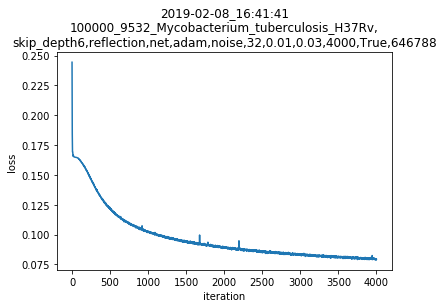

In [10]:
coding = [c['coding_part'] for c in inpaintinglog.counters]
noncoding = [c['noncoding_part'] for c in inpaintinglog.counters]
mask = [c['mask_part'] for c in inpaintinglog.counters]


In [120]:
def plot_part(coding, name):
    fig = plt.plot(coding)
    plt.ylim(0.65, 0.75)
    plt.ylabel('mistakes in {} part'.format(name))
    plt.xlabel('iteration/{}'.format(inpaintinglog.out_nps_every))
    plt.title(inpaintinglog.plot_title)
    plt.tight_layout()
    plt.savefig("pics/{}_{}.png".format(inpaintinglog.file_title, name))
    plt.show()

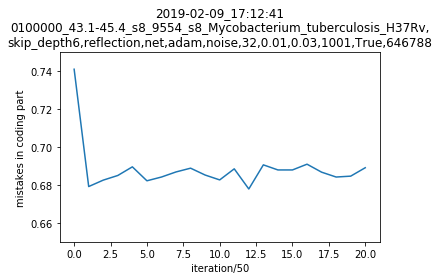

In [121]:
plot_part(coding, "coding")

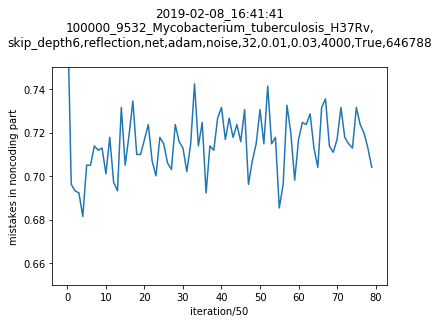

In [13]:
plot_part(noncoding, "noncoding")

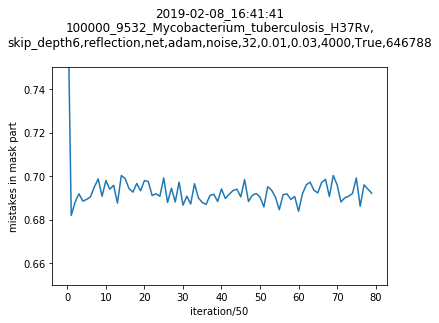

In [14]:

plot_part(mask, "mask")

In [23]:
from Bio import SeqIO
iterator = SeqIO.parse(myco, "genbank")
record = next(iterator)
length = (len(record.seq))
# # print(record.annotations.keys())
# # print(record.features[0].type)
# # print(dir(record.features[5].location))
# # print(record.features[5].location.start)
          
coding = np.zeros(length)
for f in record.features:
    if f.type == "CDS":
        f_start = f.location.start
        f_end = f.location.end
        coding[f_start: f_end] = 1 

cds = []
non = []
previous_value = 2
last_switch_i = 0
for i in range(length + 1):
    if i == length:
        current_value = 2
    else:
        current_value = coding[i]
        
    if current_value != previous_value:
#         print("switch at {}".format(i))
        l = i - last_switch_i
#         print(l)
        if current_value == 1:
            cds.append(l)
        else:
            non.append(l)
        last_switch_i = i
    previous_value = current_value
              
# print('_'.join(record.description.split(' ')[0:3])
print(sum(coding))
print(sum(cds) + sum (non))
print(len(record.seq))
print(np.mean(cds), len(cds), sum(cds))
print(np.mean(non), len(non), sum(non))

3947191.0
4411532
4411532
155.61677852348993 2980 463738
1324.318685005032 2981 3947794
